In [30]:
import matplotlib.pyplot as plt

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import pandas as pd

# Load datasets using direct Google Drive links
customers = pd.read_csv('https://drive.google.com/uc?id=1q1CAF7RaH0uM2X4ehHRRqbQJr7utqzWf')
products = pd.read_csv('https://drive.google.com/uc?id=1w5ztz7bqbYJYsvY2Sj4tfFJuSWd3cEhJ')
transactions = pd.read_csv('https://drive.google.com/uc?id=1z4DK_nmAzyRnjIqQXrDC98h-b5BAahdr')

# Verify data
print(customers.info())
print(products.info())
print(transactions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------

In [18]:
# Convert date columns to datetime format
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])


In [19]:
print(customers.duplicated().sum())  # Check for duplicates in customers
print(products.duplicated().sum())  # Check for duplicates in products
print(transactions.duplicated().sum())  # Check for duplicates in transactions


0
0
0


In [20]:
# Verify relationships between datasets
print(set(transactions['CustomerID']).issubset(set(customers['CustomerID'])))
print(set(transactions['ProductID']).issubset(set(products['ProductID'])))


True
True


In [21]:
# Merge datasets to create a unified dataset
merged_data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

# Verify the merged dataset
print(merged_data.info())
print(merged_data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TransactionID    1000 non-null   object        
 1   CustomerID       1000 non-null   object        
 2   ProductID        1000 non-null   object        
 3   TransactionDate  1000 non-null   datetime64[ns]
 4   Quantity         1000 non-null   int64         
 5   TotalValue       1000 non-null   float64       
 6   Price_x          1000 non-null   float64       
 7   CustomerName     1000 non-null   object        
 8   Region           1000 non-null   object        
 9   SignupDate       1000 non-null   datetime64[ns]
 10  ProductName      1000 non-null   object        
 11  Category         1000 non-null   object        
 12  Price_y          1000 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(1), object(7)
memory usage: 101.7+ KB
None
  Transacti

In [22]:
# Remove redundant columns and rename for clarity
merged_data = merged_data.drop(columns=['Price_x'])
merged_data.rename(columns={'Price_y': 'Price'}, inplace=True)

In [24]:
# Feature Engineering
# Calculate Customer Age in days (time since signup as of the latest transaction)
merged_data['CustomerAge'] = (merged_data['TransactionDate'].max() - merged_data['SignupDate']).dt.days

# Extract Transaction Month and Year for seasonal analysis
merged_data['TransactionMonth'] = merged_data['TransactionDate'].dt.month
merged_data['TransactionYear'] = merged_data['TransactionDate'].dt.year

# Calculate Revenue Per Unit for granular product-level analysis
merged_data['RevenuePerUnit'] = merged_data['TotalValue'] / merged_data['Quantity']

# Verify the newly added features
print(merged_data[['CustomerID', 'CustomerAge', 'TransactionMonth', 'TransactionYear', 'RevenuePerUnit']].head())



  CustomerID  CustomerAge  TransactionMonth  TransactionYear  RevenuePerUnit
0      C0199          756                 8             2024          300.68
1      C0146          115                 5             2024          300.68
2      C0127          268                 4             2024          300.68
3      C0087          261                 3             2024          300.68
4      C0070         1019                 3             2024          300.68


In [25]:
# Categorize customers into loyalty groups
def categorize_loyalty(age):
    if age < 365:
        return 'New'
    elif age < 730:
        return 'Regular'
    else:
        return 'Loyal'

merged_data['CustomerLoyalty'] = merged_data['CustomerAge'].apply(categorize_loyalty)

# Verify the new feature
print(merged_data[['CustomerID', 'CustomerAge', 'CustomerLoyalty']].head())


  CustomerID  CustomerAge CustomerLoyalty
0      C0199          756           Loyal
1      C0146          115             New
2      C0127          268             New
3      C0087          261             New
4      C0070         1019           Loyal


In [26]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

merged_data['Season'] = merged_data['TransactionMonth'].apply(get_season)

# Verify the new feature
print(merged_data[['TransactionMonth', 'Season']].head())


   TransactionMonth  Season
0                 8  Summer
1                 5  Spring
2                 4  Spring
3                 3  Spring
4                 3  Spring


In [27]:
#Calculate Customer Lifetime Value (CLV)
customer_clv = merged_data.groupby('CustomerID')['TotalValue'].sum().reset_index()
customer_clv.rename(columns={'TotalValue': 'CLV'}, inplace=True)

# Merge the CLV back into the dataset
merged_data = merged_data.merge(customer_clv, on='CustomerID', how='left')

# Verify the new feature
print(merged_data[['CustomerID', 'CLV']].head())


  CustomerID      CLV
0      C0199  1979.28
1      C0146  2570.80
2      C0127  3232.88
3      C0087  6604.23
4      C0070  3125.49


In [52]:
# Verify the enriched dataset
print(merged_data.head())

  TransactionID CustomerID ProductID     TransactionDate  Quantity  \
0        T00001      C0199      P067 2024-08-25 12:38:23         1   
1        T00112      C0146      P067 2024-05-27 22:23:54         1   
2        T00166      C0127      P067 2024-04-25 07:38:55         1   
3        T00272      C0087      P067 2024-03-26 22:55:37         2   
4        T00363      C0070      P067 2024-03-21 15:10:10         3   

   TotalValue     CustomerName         Region SignupDate  \
0      300.68   Andrea Jenkins         Europe 2022-12-03   
1      300.68  Brittany Harvey           Asia 2024-09-04   
2      300.68  Kathryn Stevens         Europe 2024-04-04   
3      601.36  Travis Campbell  South America 2024-04-11   
4      902.04    Timothy Perez         Europe 2022-03-15   

                       ProductName     Category   Price  CustomerAge  \
0  ComfortLiving Bluetooth Speaker  Electronics  300.68          756   
1  ComfortLiving Bluetooth Speaker  Electronics  300.68          115   
2 

In [28]:
#EDA
# Basic summary statistics
print(merged_data.describe())

# Check for missing values
print(merged_data.isnull().sum())

# Check the unique values in key columns
print("Unique Customers:", merged_data['CustomerID'].nunique())
print("Unique Products:", merged_data['ProductID'].nunique())
print("Unique Categories:", merged_data['Category'].nunique())


                     TransactionDate     Quantity   TotalValue  \
count                           1000  1000.000000  1000.000000   
mean   2024-06-23 15:33:02.768999936     2.537000   689.995560   
min              2023-12-30 15:29:12     1.000000    16.080000   
25%       2024-03-25 22:05:34.500000     2.000000   295.295000   
50%       2024-06-26 17:21:52.500000     3.000000   588.880000   
75%              2024-09-19 14:19:57     4.000000  1011.660000   
max              2024-12-28 11:00:00     4.000000  1991.040000   
std                              NaN     1.117981   493.144478   

                          SignupDate       Price  CustomerAge  \
count                           1000  1000.00000  1000.000000   
mean   2023-07-09 02:49:55.199999744   272.55407   537.882000   
min              2022-01-22 00:00:00    16.08000     0.000000   
25%              2022-09-17 12:00:00   147.95000   260.000000   
50%              2023-07-23 00:00:00   299.93000   524.000000   
75%            

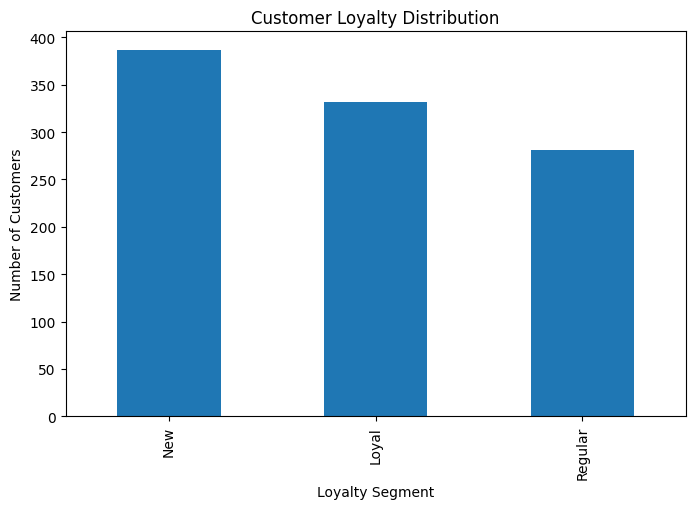

In [31]:
#Customer loyalty distribution
loyalty_counts = merged_data['CustomerLoyalty'].value_counts()
loyalty_counts.plot(kind='bar', title='Customer Loyalty Distribution', figsize=(8, 5))
plt.xlabel('Loyalty Segment')
plt.ylabel('Number of Customers')
plt.show()


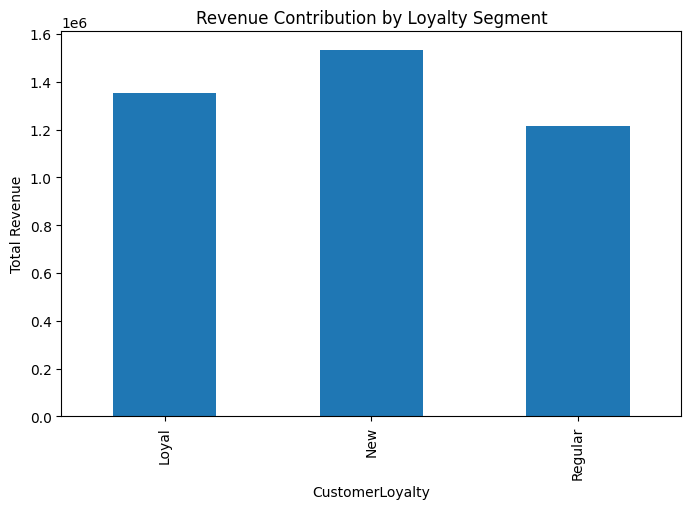

In [33]:
#Customer Revenue Contribution by Loyalty
revenue_by_loyalty = merged_data.groupby('CustomerLoyalty')['CLV'].sum()
revenue_by_loyalty.plot(kind='bar', title='Revenue Contribution by Loyalty Segment', figsize=(8, 5))
plt.ylabel('Total Revenue')
plt.show()


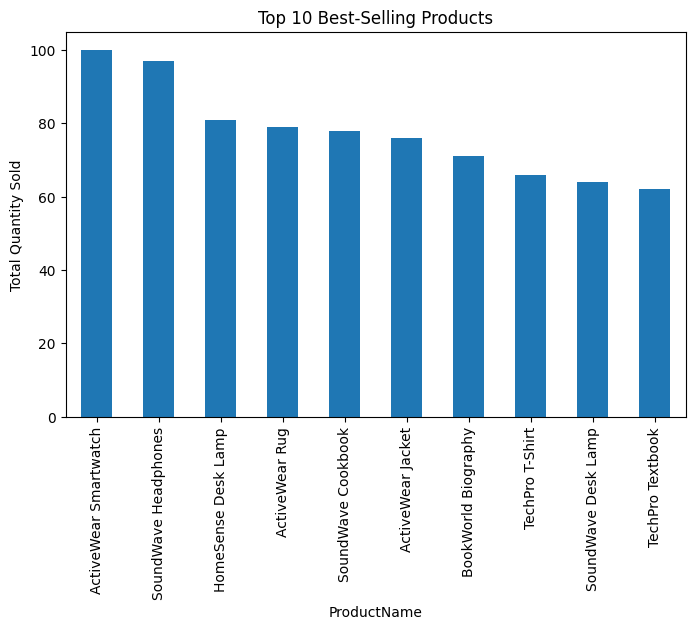

In [35]:
#Top 10 Best-Selling Products
top_products = merged_data.groupby('ProductName')['Quantity'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='bar', title='Top 10 Best-Selling Products', figsize=(8, 5))
plt.ylabel('Total Quantity Sold')
plt.show()

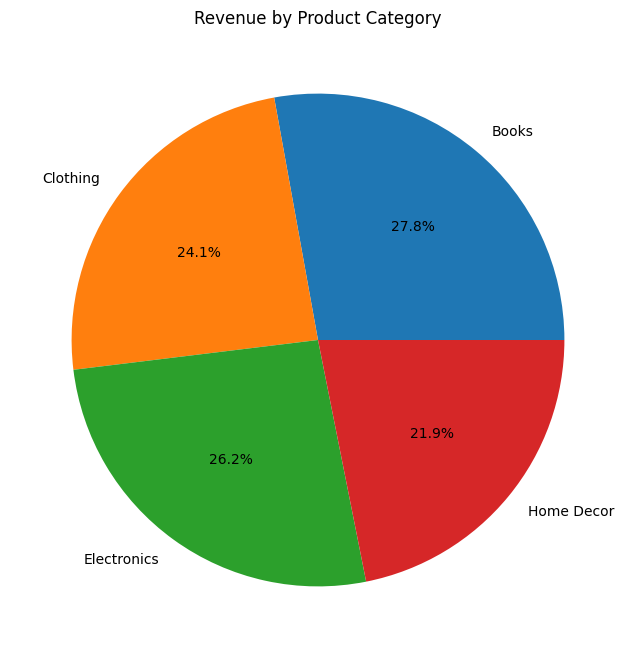

In [36]:
#Revenue by Product Category
category_revenue = merged_data.groupby('Category')['TotalValue'].sum()
category_revenue.plot(kind='pie', autopct='%1.1f%%', title='Revenue by Product Category', figsize=(8, 8))
plt.ylabel('')
plt.show()


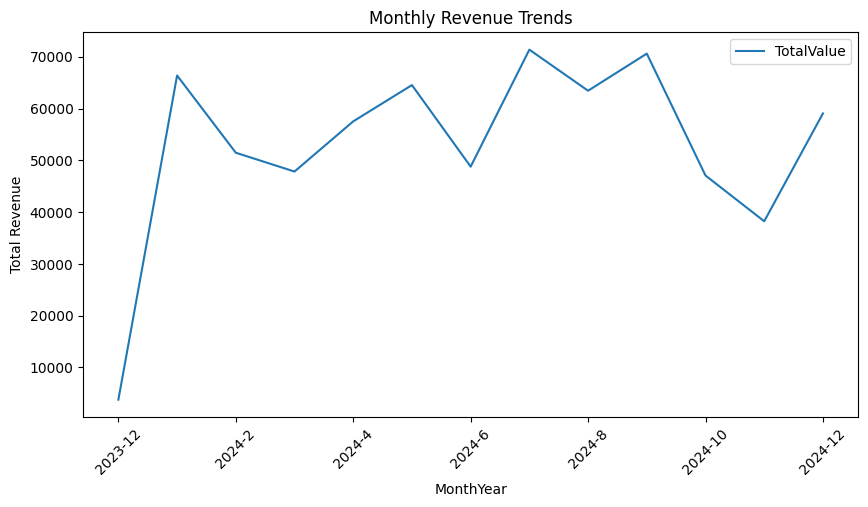

In [37]:
#Transaction Trends
#Monthly Revenue Trends
monthly_revenue = merged_data.groupby(['TransactionYear', 'TransactionMonth'])['TotalValue'].sum().reset_index()
monthly_revenue['MonthYear'] = monthly_revenue['TransactionYear'].astype(str) + '-' + monthly_revenue['TransactionMonth'].astype(str)
monthly_revenue.plot(x='MonthYear', y='TotalValue', kind='line', title='Monthly Revenue Trends', figsize=(10, 5))
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.show()

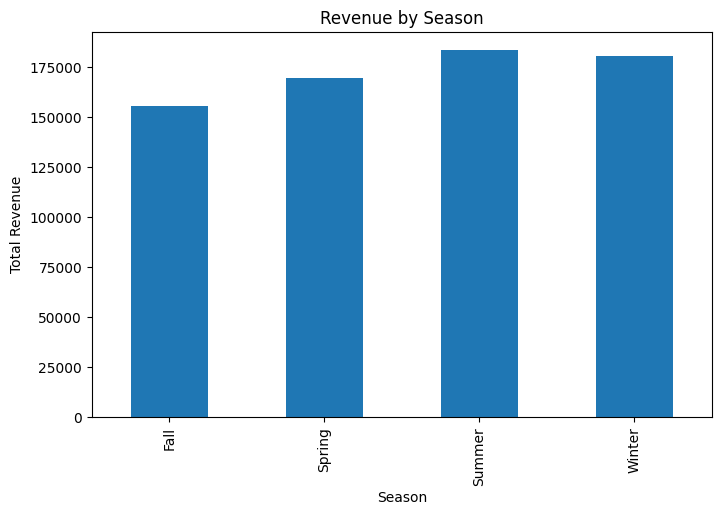

In [38]:
#Seasonal Revenue Trends
seasonal_revenue = merged_data.groupby('Season')['TotalValue'].sum()
seasonal_revenue.plot(kind='bar', title='Revenue by Season', figsize=(8, 5))
plt.xlabel('Season')
plt.ylabel('Total Revenue')
plt.show()

In [39]:
avg_revenue_per_customer = merged_data.groupby('CustomerID')['TotalValue'].sum().mean()
print("Average Revenue per Customer:", avg_revenue_per_customer)

Average Revenue per Customer: 3467.314371859297


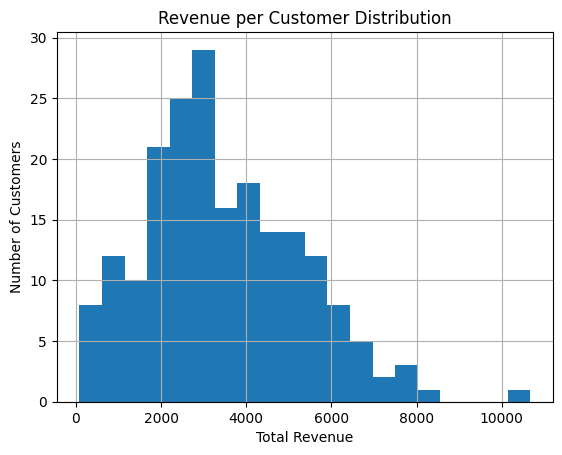

In [40]:
merged_data.groupby('CustomerID')['TotalValue'].sum().hist(bins=20)
plt.title('Revenue per Customer Distribution')
plt.xlabel('Total Revenue')
plt.ylabel('Number of Customers')
plt.show()


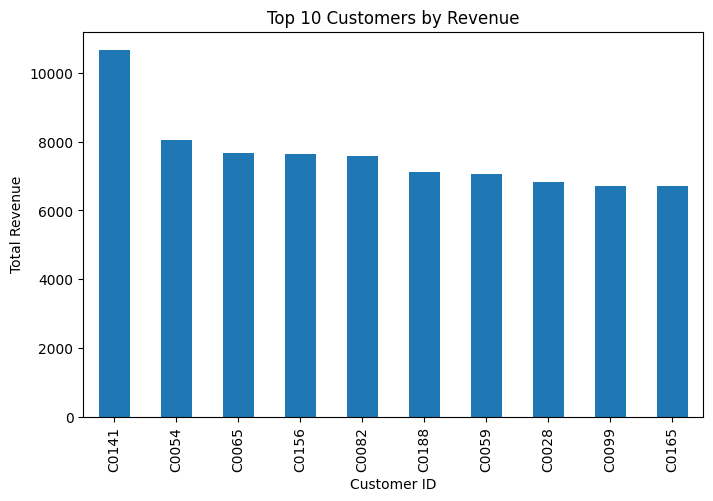

In [44]:
#Identify Top Customers
top_customers.plot(kind='bar', title='Top 10 Customers by Revenue', figsize=(8, 5))
plt.xlabel('Customer ID')
plt.ylabel('Total Revenue')
plt.show()


In [45]:
total_revenue = merged_data['TotalValue'].sum()
top_10_revenue = top_customers.sum()
contribution_percentage = (top_10_revenue / total_revenue) * 100
print(f"Top 10 Customers Contribution to Total Revenue: {contribution_percentage:.2f}%")


Top 10 Customers Contribution to Total Revenue: 11.02%


In [47]:
#Compare with Other Segments
bottom_50_revenue = merged_data.groupby('CustomerID')['TotalValue'].sum().sort_values().head(len(merged_data['CustomerID'].unique()) // 2).sum()
bottom_50_contribution = (bottom_50_revenue / total_revenue) * 100
print(f"Bottom 50% Customers Contribution to Total Revenue: {bottom_50_contribution:.2f}%")


Bottom 50% Customers Contribution to Total Revenue: 28.76%


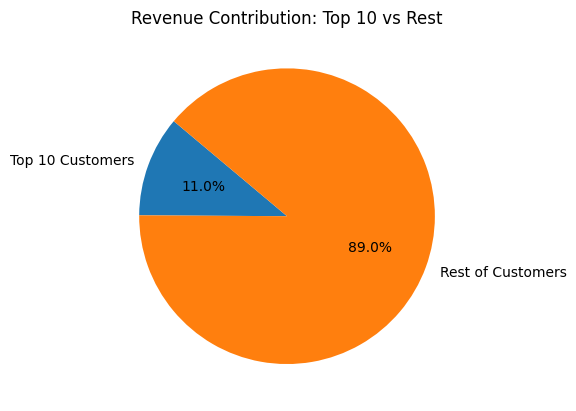

In [48]:
contributions = {
    'Top 10 Customers': top_10_revenue,
    'Rest of Customers': total_revenue - top_10_revenue
}
plt.pie(contributions.values(), labels=contributions.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Revenue Contribution: Top 10 vs Rest')
plt.show()


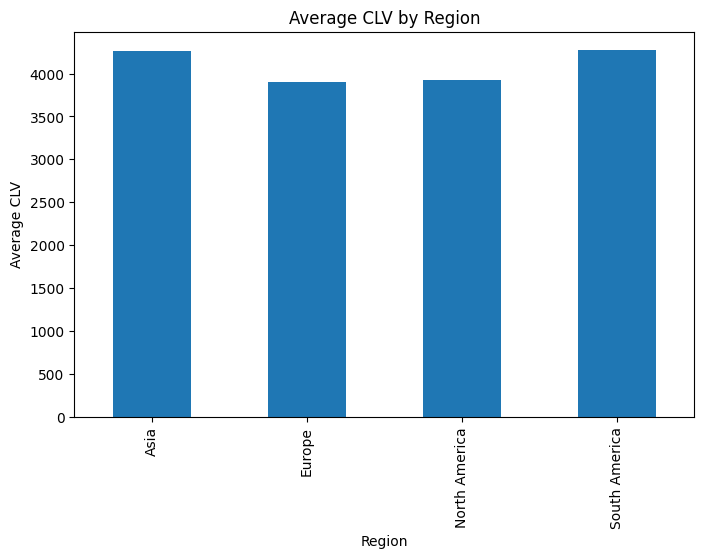

In [50]:
#Average CLV by region
region_clv = merged_data.groupby('Region')['CLV'].mean()
region_clv.plot(kind='bar', title='Average CLV by Region', figsize=(8, 5))
plt.ylabel('Average CLV')
plt.show()
